In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier




In [344]:
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,Unnamed: 0,blueGoldDiff,blueExperienceDiff,blueGoldPerMin,blueTotalGold,blueTotalExperience,blueAvgLevel,blueKills,redDeaths,blueAssists,...,redAssists,blueDeaths,redKills,redAvgLevel,redTotalExperience,redTotalGold,redGoldPerMin,redExperienceDiff,redGoldDiff,blueWins
0,0,643,-8,1721.0,17210,17039,6.6,9,9,11,...,8,6,6,6.8,17047,16567,1656.7,8,-643,0
1,1,-2908,-1173,1471.2,14712,16265,6.6,5,5,5,...,2,5,5,6.8,17438,17620,1762.0,1173,2908,0
2,2,-1172,-1033,1611.3,16113,16221,6.4,7,7,4,...,14,11,11,6.8,17254,17285,1728.5,1033,1172,0
3,3,-1321,-7,1515.7,15157,17954,7.0,4,4,5,...,10,5,5,7.0,17961,16478,1647.8,7,1321,0
4,4,-1004,230,1640.0,16400,18543,7.0,6,6,6,...,7,6,6,7.0,18313,17404,1740.4,-230,1004,0


In [345]:
# W're going to drop a number of columns. These features are the inverse of other features, so they do not provide our model with useful data.
# If we leave these features in it will cause our model be more ill-conditioned (these features are just linear combinations of other features)
df.drop(columns = ['Unnamed: 0', 'redGoldDiff', 'redExperienceDiff', 'redKills', 'redDeaths'], axis = 1, inplace = True)
df.head()

,blueGoldDiff,blueExperienceDiff,blueGoldPerMin,blueTotalGold,blueTotalExperience,blueAvgLevel,blueKills,blueAssists,blueTotalMinionsKilled,blueCSPerMin,...,redTotalMinionsKilled,redCSPerMin,redEliteMonsters,redAssists,blueDeaths,redAvgLevel,redTotalExperience,redTotalGold,redGoldPerMin,blueWins
0,643,-8,1721.0,17210,17039,6.6,9,11,195,19.5,...,197,19.7,0,8,6,6.8,17047,16567,1656.7,0
1,-2908,-1173,1471.2,14712,16265,6.6,5,5,174,17.4,...,240,24.0,2,2,5,6.8,17438,17620,1762.0,0
2,-1172,-1033,1611.3,16113,16221,6.4,7,4,186,18.6,...,203,20.3,0,14,11,6.8,17254,17285,1728.5,0
3,-1321,-7,1515.7,15157,17954,7.0,4,5,201,20.1,...,235,23.5,0,10,5,7.0,17961,16478,1647.8,0
4,-1004,230,1640.0,16400,18543,7.0,6,6,210,21.0,...,225,22.5,1,7,6,7.0,18313,17404,1740.4,0


In [346]:
# This class does a number of things. It does PCA analysis if desired. 
# It also allows for any model type to be loaded into it and analyzed with and without the data scaled
class modeler():
    
    def __init__(self, X, y):
        #Out initialization takes in our X features and Y target
        self.params = None
        self.model_type = None
        self.X = X
        self.y = y
        # Test train split on the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, stratify = self.y)
        
        # Scale the data
        sc = StandardScaler()
        self.Z_train = sc.fit_transform(self.X_train)
        self.Z_test = sc.transform(self.X_test)
        self.Z = sc.fit_transform(self.X)
    
        
    def PCA(self, degree):
        # Takes in a 'degree' variable with defines how many poly features will be added
        print(f'Creating Polynomial Features of degree {degree}')
        pf = PolynomialFeatures(degree)

        X_new = pf.fit_transform(self.Z)
        
        # Fit the PCA model
        pca = PCA()
        pca.fit(X_new)
        print('Calculating Explained Variance...')
        
        # Explained variance
        var_exp = pca.explained_variance_ratio_
        print(f'Explained variance (first 20 componenets): {np.round(var_exp[:20], 3)}')

        print(' ')

        # Generate the cumulative explained variance.
        cum_var_exp = np.cumsum(var_exp)
        print(f'Cumulative explained variance (first 10 components): {np.round(cum_var_exp[:10], 3)}')
        
        print(' ')
        print('Calculating LogisticRegression Analysis...')
        print(' ')
        # New train-test split with our new poly features
        X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, self.y, stratify = self.y)
        
        pca_train = pca.transform(X_train_new)
        pca_test = pca.transform(X_test_new)
        # Pull the explained variance attribute.
        
        # Instantiate logistic regression model.
        
        log_params = {
            'C' : [.00001, .0001, .001, .01, 1],
            'solver' : ['liblinear']
            }
        
        log_gridsearch = GridSearchCV(LogisticRegression(), # What is the model we want to fit?
                              param_grid=log_params, # What is the dictionary of hyperparameters?
                              cv=5) 

        # Fit on Z_train and print metrics
        log_gridsearch.fit(pca_train, y_train_new)
        
        print(f'Best PCA Train score for Gridsearch: {log_gridsearch.best_score_}')
        
        best = log_gridsearch.best_estimator_
        
        print(f'Best Test score for Gridsearch {best.score(pca_test, y_test_new)}')

        
    
    def analyzer(self, model_type, params):
        # Takes a model type with it's associated parameters
        self.params = params
        self.model_type = model_type

        print(f'Method being used: {self.model_type}')
        
        model = self.model_type
        model.fit(self.X_train, self.y_train)

        # metrics with no grid search, scaled and unscalec
        print(f'Method Test r2 with no scaling or Gridsearching: {np.round(model.score(self.X_test, self.y_test), 3)}')

        model.fit(self.Z_train, self.y_train)
        print(f'Method Test r2 with scaling but no Gridsearching: {np.round(model.score(self.Z_test, self.y_test), 3)}')
        print(' ')

        # Instantiate our GridSearchCV object.
        model_gridsearch = GridSearchCV(model, # What is the model we want to fit?
                                      param_grid = self.params, # What is the dictionary of hyperparameters?
                                      cv=5) 
        
        # Fit our model and print metrics
        model_gridsearch.fit(self.X_train, self.y_train);
        print(f'Best Train score for Gridsearched w/out scaling {np.round(model_gridsearch.best_score_, 3)}')
        
        best = model_gridsearch.best_estimator_
        
        print(f'Best Test score for Gridsearched w/out scaling {np.round(best.score(self.X_test, self.y_test), 3)}')
        print(' ')
        

        model_gridsearch.fit(self.Z_train, self.y_train);
        print(f'Best Train score for Gridsearched w/ scaling {np.round(model_gridsearch.best_score_, 3)}')
        
        best = model_gridsearch.best_estimator_
        
        print(f'Best Test score for Gridsearched w/ scaling {np.round(best.score(self.Z_test, self.y_test), 3)}')        
        
        return best
        
        


In [347]:
df.columns

Index(['blueGoldDiff', 'blueExperienceDiff', 'blueGoldPerMin', 'blueTotalGold',
       'blueTotalExperience', 'blueAvgLevel', 'blueKills', 'blueAssists',
       'blueTotalMinionsKilled', 'blueCSPerMin', 'blueEliteMonsters',
       'blueDragons', 'blueFirstBlood', 'redFirstBlood', 'redDragons',
       'redTotalMinionsKilled', 'redCSPerMin', 'redEliteMonsters',
       'redAssists', 'blueDeaths', 'redAvgLevel', 'redTotalExperience',
       'redTotalGold', 'redGoldPerMin', 'blueWins'],
      dtype='object')

In [348]:
# We'll add some engineered features
df['eng1'] = df['blueTotalGold']*df['redTotalGold']/10
df['eng2'] = df['blueGoldPerMin']*df['redGoldPerMin']/10
df['eng3'] = df['blueTotalMinionsKilled']*df['redTotalMinionsKilled']/10
df['eng4'] = df['blueTotalExperience']*df['redTotalExperience']/10
df['eng5'] = df['blueTotalGold']*df['blueTotalGold']
df['eng6'] = df['blueTotalExperience']*df['blueTotalExperience']

In [349]:
# Create our features and target
X = df.drop(columns = 'blueWins', axis = 1)
y = df['blueWins']

# Fit model
model = modeler(X, y)

In [350]:
# First we'll check out KNN
params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}
model.analyzer(KNeighborsClassifier(), params)

Method being used: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Method Test r2 with no scaling or Gridsearching: 0.681
Method Test r2 with scaling but no Gridsearching: 0.683
 
Best Train score for Gridsearched w/out scaling 0.707
Best Test score for Gridsearched w/out scaling 0.712
 
Best Train score for Gridsearched w/ scaling 0.72
Best Test score for Gridsearched w/ scaling 0.714


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [351]:
# Let's look at RandomForest next, it does a little better than KNN
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
model.analyzer(RandomForestClassifier(), params)

Method being used: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Method Test r2 with no scaling or Gridsearching: 0.72
Method Test r2 with scaling but no Gridsearching: 0.711
 
Best Train score for Gridsearched w/out scaling 0.732
Best Test score for Gridsearched w/out scaling 0.716
 
Best Train score for Gridsearched w/ scaling 0.732
Best Test score for Gridsearched w/ scaling 0.716


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [352]:
# Let's look at ExtraTrees next
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
model.analyzer(ExtraTreesClassifier(), params)

Method being used: ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Method Test r2 with no scaling or Gridsearching: 0.713
Method Test r2 with scaling but no Gridsearching: 0.712
 
Best Train score for Gridsearched w/out scaling 0.732
Best Test score for Gridsearched w/out scaling 0.721
 
Best Train score for Gridsearched w/ scaling 0.732
Best Test score for Gridsearched w/ scaling 0.722


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=150,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [353]:
# Let's run a standard Logistic Regression model without our engineered features to see what the odds from each coef is
X_2 = X.drop(columns = ['eng1', 'eng2', 'eng3', 'eng4', 'eng5', 'eng6'], axis = 1).copy()
X_2.columns

Index(['blueGoldDiff', 'blueExperienceDiff', 'blueGoldPerMin', 'blueTotalGold',
       'blueTotalExperience', 'blueAvgLevel', 'blueKills', 'blueAssists',
       'blueTotalMinionsKilled', 'blueCSPerMin', 'blueEliteMonsters',
       'blueDragons', 'blueFirstBlood', 'redFirstBlood', 'redDragons',
       'redTotalMinionsKilled', 'redCSPerMin', 'redEliteMonsters',
       'redAssists', 'blueDeaths', 'redAvgLevel', 'redTotalExperience',
       'redTotalGold', 'redGoldPerMin'],
      dtype='object')

In [354]:
model = modeler(X_2, y)

In [355]:
params = {
    'C' : [.00001, .0001, .001, .01, 1],
    'solver' : ['liblinear']
    }
best_model = model.analyzer(LogisticRegression(), params)

Method being used: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Method Test r2 with no scaling or Gridsearching: 0.736
Method Test r2 with scaling but no Gridsearching: 0.734
 
Best Train score for Gridsearched w/out scaling 0.727
Best Test score for Gridsearched w/out scaling 0.745
 
Best Train score for Gridsearched w/ scaling 0.732
Best Test score for Gridsearched w/ scaling 0.732


In [356]:
# Print our coef
best_model.coef_

array([[ 0.24729431,  0.17913701,  0.22475957,  0.22475957,  0.15202164,
         0.04452216, -0.01202619, -0.01765547, -0.024987  , -0.024987  ,
         0.01357659,  0.16258861,  0.03521872, -0.03521872, -0.0827981 ,
         0.00563138,  0.00563138, -0.06965029,  0.03417377, -0.08345147,
        -0.0305981 , -0.1340595 , -0.1765829 , -0.1765829 ]])

In [365]:
# Exponentiate our coef's and print them with their associated features
odds = list(np.exp(best_model.coef_))
odds = odds[0]
print('Exponentiate our coefs:')
print('')
for i in range(len(X_2.columns)):
    if odds[i] > 1.1:
        print(X_2.columns[i])
        print(np.round(odds[i], 3))
        print(' ')

                

Exponentiate our coefs:

blueGoldDiff
1.281
 
blueExperienceDiff
1.196
 
blueGoldPerMin
1.252
 
blueTotalGold
1.252
 
blueTotalExperience
1.164
 
blueDragons
1.177
 


In [366]:
X_2.columns

Index(['blueGoldDiff', 'blueExperienceDiff', 'blueGoldPerMin', 'blueTotalGold',
       'blueTotalExperience', 'blueAvgLevel', 'blueKills', 'blueAssists',
       'blueTotalMinionsKilled', 'blueCSPerMin', 'blueEliteMonsters',
       'blueDragons', 'blueFirstBlood', 'redFirstBlood', 'redDragons',
       'redTotalMinionsKilled', 'redCSPerMin', 'redEliteMonsters',
       'redAssists', 'blueDeaths', 'redAvgLevel', 'redTotalExperience',
       'redTotalGold', 'redGoldPerMin'],
      dtype='object')

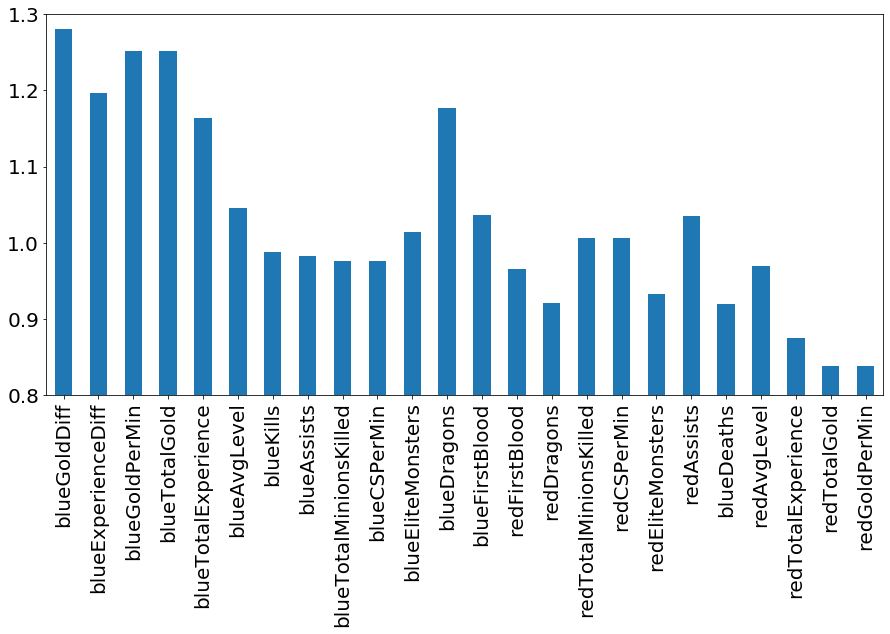

In [368]:
# Plot our odds and look at what features have the largest odds
pd.Series(odds, index=X_2.columns).plot.bar(figsize=(15, 7))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0.8, ymax=1.3);